<strong>Classification of Expected User Knowledge From User Metrics

<strong>Introduction:</strong>
In the area of education, there are multiple metrics which can be evaluated in order to rate a student's performance. For example, the relationship between study time, repetition, and exam performance all correlate to a users level of knowledge. This data is most often used in standardised testing such as the ACT and SAT to evaluate admissions to a university. As there are too many students across multiple school systems, countries, and levels of educational achievement, using certain performance metrics to guess knowledge level becomes important. In our project, we will attempt to answer the question, how adept at a task would a person be based on their level of study time, repetition, and exam performance? Our data set, user knowledge, will be used to answer this question as it has data covering multiple performance categories both on a given task and related tasks.

<strong>Preliminary exploratory data analysis:

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(httr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Attribute Information:\
STG: The degree of study time for goal object materails.\
SCG: The degree of repetition number of user for goal object materails.\
STR: The degree of study time of user for related objects with goal object.\
LPR: The exam performance of user for related objects with goal object.\
PEG: The exam performance of user for goal objects.\
UNS: The knowledge level of user.

In [3]:
# load data in and convert <chr> to <fct> for categorical variable UNS
url<-'https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls'
GET(url, write_disk(TF <- tempfile(fileext = ".xls")))

user_training_raw <- read_excel(TF, sheet = "Training_Data")
user_training <- select(user_training_raw, STG:UNS)
user_training[user_training == "very_low"] <- "Very Low"
user_training <- mutate(user_training, UNS = as_factor(UNS))
head(user_training)

user_testing_raw <- read_excel(TF, sheet = "Test_Data")
user_testing <- select(user_testing_raw, STG:UNS)
user_testing <- mutate(user_testing, UNS = as_factor(UNS))
head(user_testing)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls]
  Date: 2022-04-07 18:26
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 57.9 kB
<ON DISK>  /tmp/RtmptGRwRZ/file5a423a00fa.xlsNULL

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


First, we want to have a quick inspection into the data. More specifically, we want to know the overall mean of all the qutitative variables as well as the mean after grouping the observation by their UNS categories. Doing this might allows us to find some patterns and provides more information for further analysis.

In [4]:
# mean of all the observations from STG to PEG
overall_mean <- user_training %>% 
                select(STG:PEG) %>% 
                map_dfr(mean)
overall_mean

num_of_observations <- nrow(user_training)
num_of_observations

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.4327132,0.4585388


[1] 258

In [5]:
# mean of observations which has "Very Low" UNS from STG to PEG
user_training_very_low <- user_training %>% 
                          filter(UNS == "Very Low")
very_low_mean <- user_training_very_low %>% 
                 select(STG:PEG) %>% 
                 map_dfr(mean)
very_low_mean

num_of_very_low <- nrow(user_training_very_low)
num_of_very_low

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3057917,0.198125,0.36625,0.35875,0.09083333


[1] 24

In [6]:
# mean of observations which has "Low" UNS from STG to PEG
user_training_low <- user_training %>% 
                     filter(UNS == "Low")
low_mean <- user_training_low %>% 
            select(STG:PEG) %>% 
            map_dfr(mean)
low_mean

num_of_low <- nrow(user_training_low)
num_of_low

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3211446,0.337,0.4307229,0.4973494,0.2376265


[1] 83

In [7]:
# mean of observations which has "Middle" UNS from STG to PEG
user_training_middle <- user_training %>% 
                        filter(UNS == "Middle")
middle_mean <- user_training_middle %>% 
               select(STG:PEG) %>% 
               map_dfr(mean)
middle_mean

num_of_middle <- nrow(user_training_middle)
num_of_middle

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3999773,0.3679205,0.5068182,0.3428409,0.5423864


[1] 88

In [8]:
# mean of observations which has "High" UNS from STG to PEG
user_training_high <- user_training %>% 
                      filter(UNS == "High")
high_mean <- user_training_high %>% 
             select(STG:PEG) %>% 
             map_dfr(mean)
high_mean

num_of_high <- nrow(user_training_high)
num_of_high

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.4216508,0.4231905,0.5016667,0.5012698,0.7725397


[1] 63

Now, we have the numerical information about the means, but it is difficult to make any inference or doing comparisons solely based on the means. What about their distributions? How can we know them? A good way is making plots to visualize everything. We decided to plot histograms for all the numerical variables. For each variable, we group the data according to their UNS categories and stack them on top of each other so it is easier for the us to do the comparisons.

In [9]:
# Reordering group factor levels
user_training$UNS <- factor(user_training$UNS, levels = c("Very Low", "Low", "Middle", "High"))
user_testing$UNS <- factor(user_testing$UNS, levels = c("Very Low", "Low", "Middle", "High"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



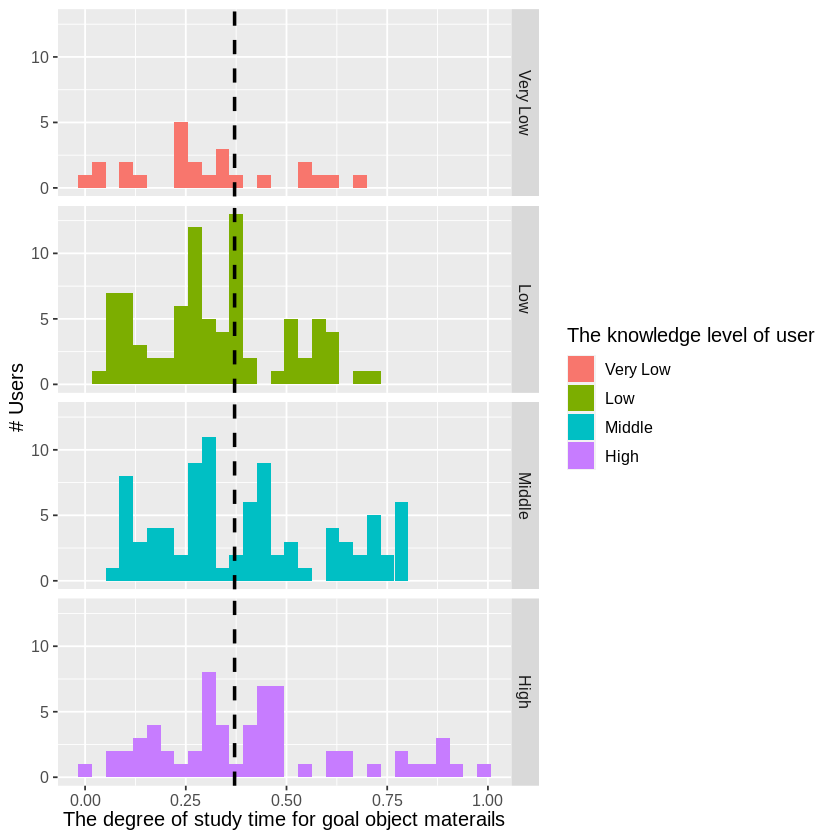

In [10]:
# For users with different knowledge level, plot the distribution of each category's degree of study time 
# for goal object materails (STG), with the overall mean of STG.
STG_plot <- user_training %>%
    select(STG,UNS) %>%
    ggplot(aes(x = STG, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.3711473, linetype = "dashed", size = 1.0) +
    labs(x = "The degree of study time for goal object materails", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 12))
STG_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



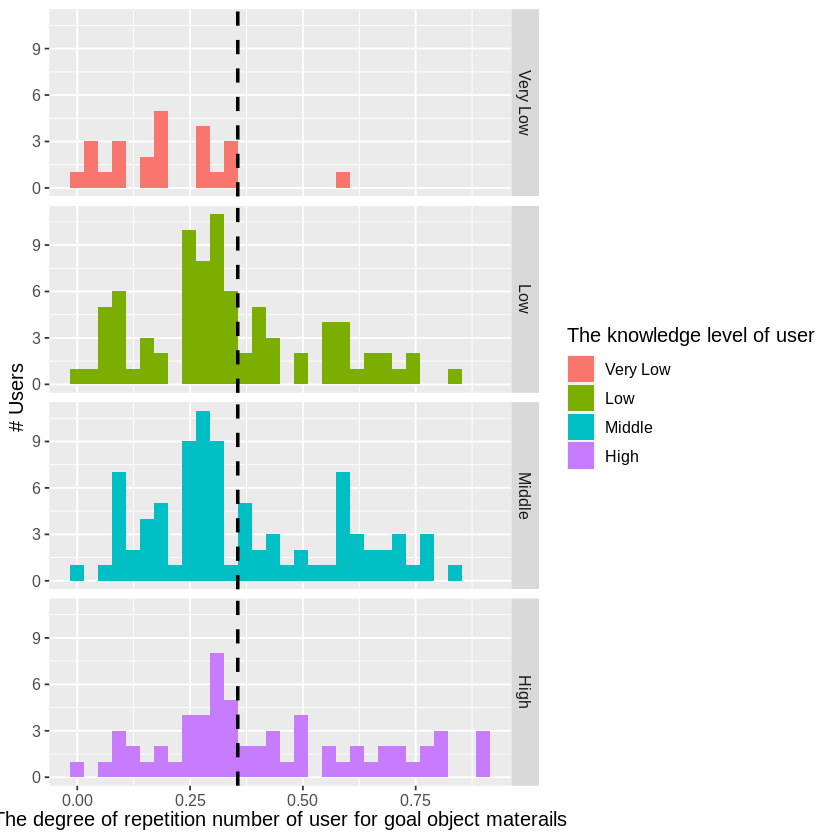

In [11]:
# For users with different knowledge level, plot the distribution of each category's degree of 
# repetition number of user for goal object materails (SCG), with the overall mean of SCG.
SCG_plot <- user_training %>%
    select(SCG,UNS) %>%
    ggplot(aes(x = SCG, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.3556744, linetype = "dashed", size = 1.0) +
    labs(x = "The degree of repetition number of user for goal object materails", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 12))
SCG_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



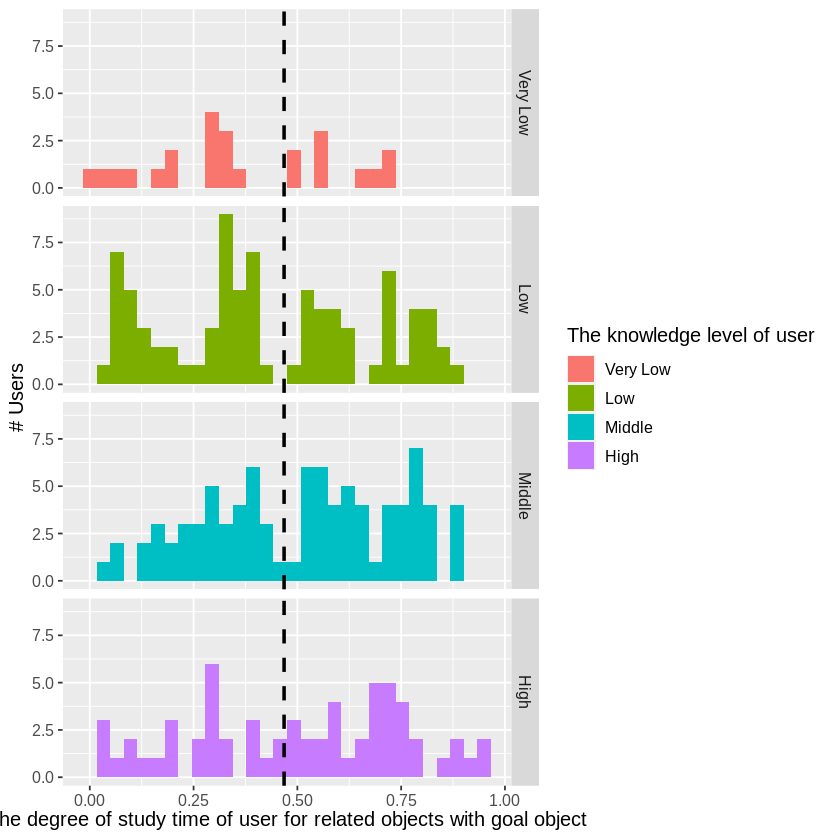

In [12]:
# For users with different knowledge level, plot the distribution of each category's degree of 
# study time of user for related objects with goal object (STR), with the overall mean of STR.
STR_plot <- user_training %>%
    select(STR,UNS) %>%
    ggplot(aes(x = STR, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.4680039, linetype = "dashed", size = 1.0) +
    labs(x = "The degree of study time of user for related objects with goal object", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 12))
STR_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



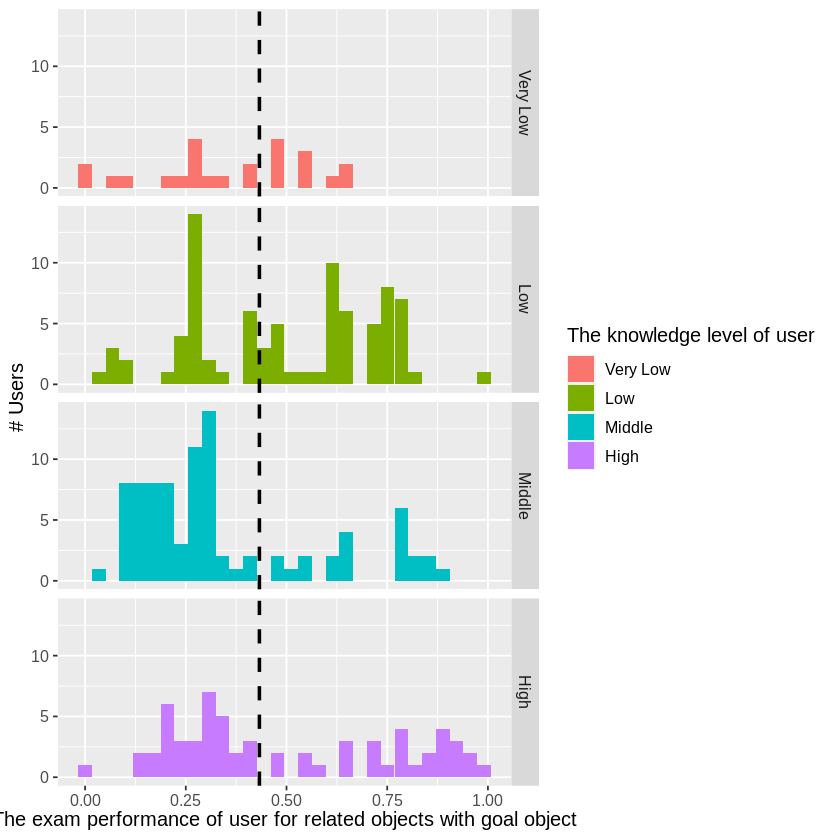

In [13]:
# For users with different knowledge level, plot the distribution of each category's performance
# for related objects with goal object (LPR), with the overall mean of lPR.
LPR_plot <- user_training %>%
    select(LPR,UNS) %>%
    ggplot(aes(x = LPR, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.4327132, linetype = "dashed", size = 1.0) +
    labs(x = "The exam performance of user for related objects with goal object", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 12))
LPR_plot 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



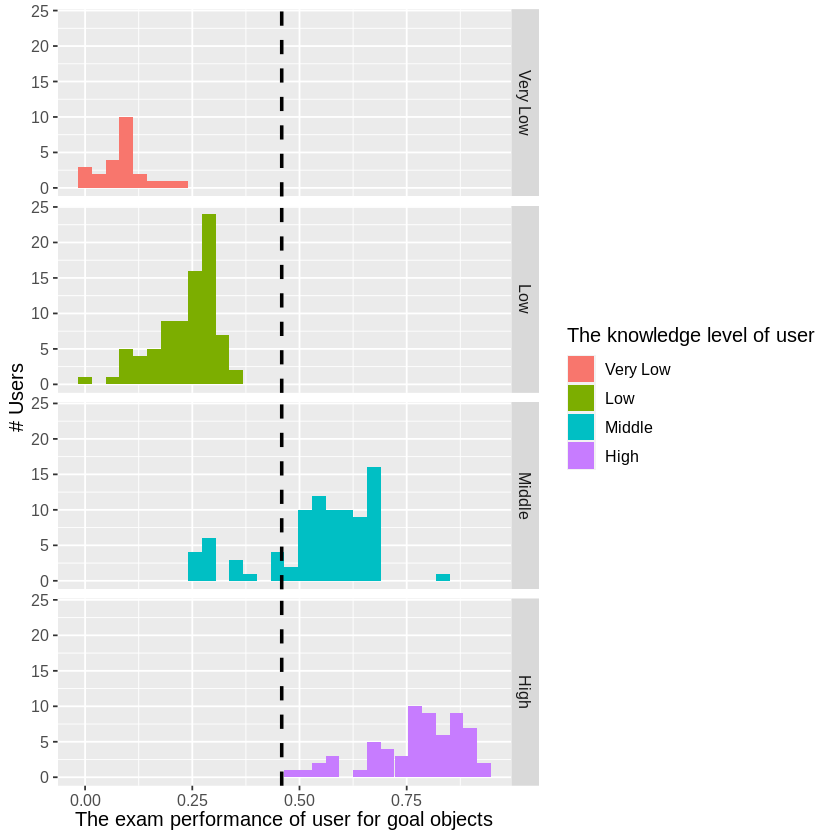

In [14]:
# For users with different knowledge level, plot the distribution of each category's exam performance 
# for goal objects(PEG), with the overall mean of PEG.
PEG_plot <- user_training %>%
    select(PEG,UNS) %>%
    ggplot(aes(x = PEG, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.4585388, linetype = "dashed", size = 1.0) +
    labs(x = "The exam performance of user for goal objects", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 12))
PEG_plot

From the plots generated above, it can be observed that, for STG, SCG and STR, the distributions of the 4 levels of users do not vary widely. For LPR, it seems like people with higher knowledge level tend to do slightly better, but this pattern is not obvious. The distributions clearly differs when it comes to PEG. This suggests that PEG can be a very important variable for predicting user's knowledge level. However, we need to do more "rigorous" analysis to support this idea.

In [15]:
# Variable Forward Selection

In [16]:
# This is the set of potential variables with the label UNS user_training

In [17]:
# extract the column names for the full set of predictor variables
names <- colnames(user_training %>% select(-UNS))

In [18]:
user_formula <- paste("UNS", "~", paste(names, collapse="+"))
user_formula

[1] "UNS ~ STG+SCG+STR+LPR+PEG"

In [19]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
cancer_vfold <- vfold_cv(user_training, v = 5, strata = UNS)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        user_recipe <- recipe(as.formula(model_string), 
                                data = user_training) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(user_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = cancer_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies 

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ PEG,0.8492308
2,UNS ~ PEG+LPR,0.9573846
3,UNS ~ PEG+LPR+SCG,0.9418462
4,UNS ~ PEG+LPR+SCG+STG,0.8796923
5,UNS ~ PEG+LPR+SCG+STG+STR,0.7747692


According to the result of forward selection of predictor variable, Using PEG and LPR will yield a more accurate prediction of UNS. Therefore, we choose PEG and LPR as the predictor variables. This is also accordant with the observation from the exploratory analysis, where we find that PEG is a good predictor. Moreover, adding LPR will give a more accurate result as is shown in the forward selection.

**Modeling**

In [20]:
# Construct KNN classification workflow
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("classification") 

knn_recipe <- recipe(UNS ~ PEG + LPR, data = user_training) %>%
       step_scale(all_predictors()) %>%
       step_center(all_predictors())

knn_workflow <- workflow() %>%
        add_recipe(knn_recipe) %>%
        add_model(knn_spec)

In [21]:
# Tune the model to find the best k (number of neighbours)
user_vfold <- vfold_cv(user_training, v = 5, strata = UNS)

gridvals <- tibble(neighbors = seq(from = 1, to = 20))

knn_fit <- knn_workflow %>%
        tune_grid(resamples = user_vfold, grid = gridvals)

knn_results <- knn_fit %>%
        collect_metrics()

k_best <- knn_results %>%
        filter(.metric == "accuracy") %>%
        arrange(mean) %>% 
        slice(1) %>%
        pull(neighbors)

k_best

[1] 19

In [22]:
# The model with the best k
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_best) %>%
          set_engine("kknn") %>%
          set_mode("classification")

knn_best_fit <- workflow() %>%
          add_recipe(knn_recipe) %>%
          add_model(knn_best_spec) %>%
          fit(data = user_training)

knn_accuracy <- knn_best_fit %>%
            predict(user_testing) %>%
            bind_cols(user_testing) 

knn_accuracy$.pred_class <- factor(knn_accuracy$.pred_class, levels = c("Very Low", "Low", "Middle","High"))

knn_accuracy %>% metrics(truth = UNS, estimate = .pred_class) %>%
            filter(.metric == "accuracy") %>%
            select(.estimate) %>%
            pull()

knn_accuracy

[1] 0.9241379

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Very Low,0.00,0.10,0.50,0.26,0.05,Very Low
Low,0.05,0.05,0.55,0.60,0.14,Low
High,0.08,0.18,0.63,0.60,0.85,High
High,0.20,0.20,0.68,0.67,0.85,High
High,0.22,0.22,0.90,0.30,0.90,High
Low,0.14,0.14,0.70,0.50,0.30,Low
Middle,0.16,0.16,0.80,0.50,0.50,Middle
Low,0.12,0.12,0.75,0.68,0.15,Low
High,0.20,0.20,0.88,0.77,0.80,High


Here we will do a visual comparation between the testing data and our prediction to get a more intuitive sence of how accurate our predictions were.
We will make two scatter plots, one for the real categories of UNS in the testing data set and the other one using our predicted categories of UNS.
We chose to put PEG in the x-axis andc LPR is the y-axis as they are the best predictors.

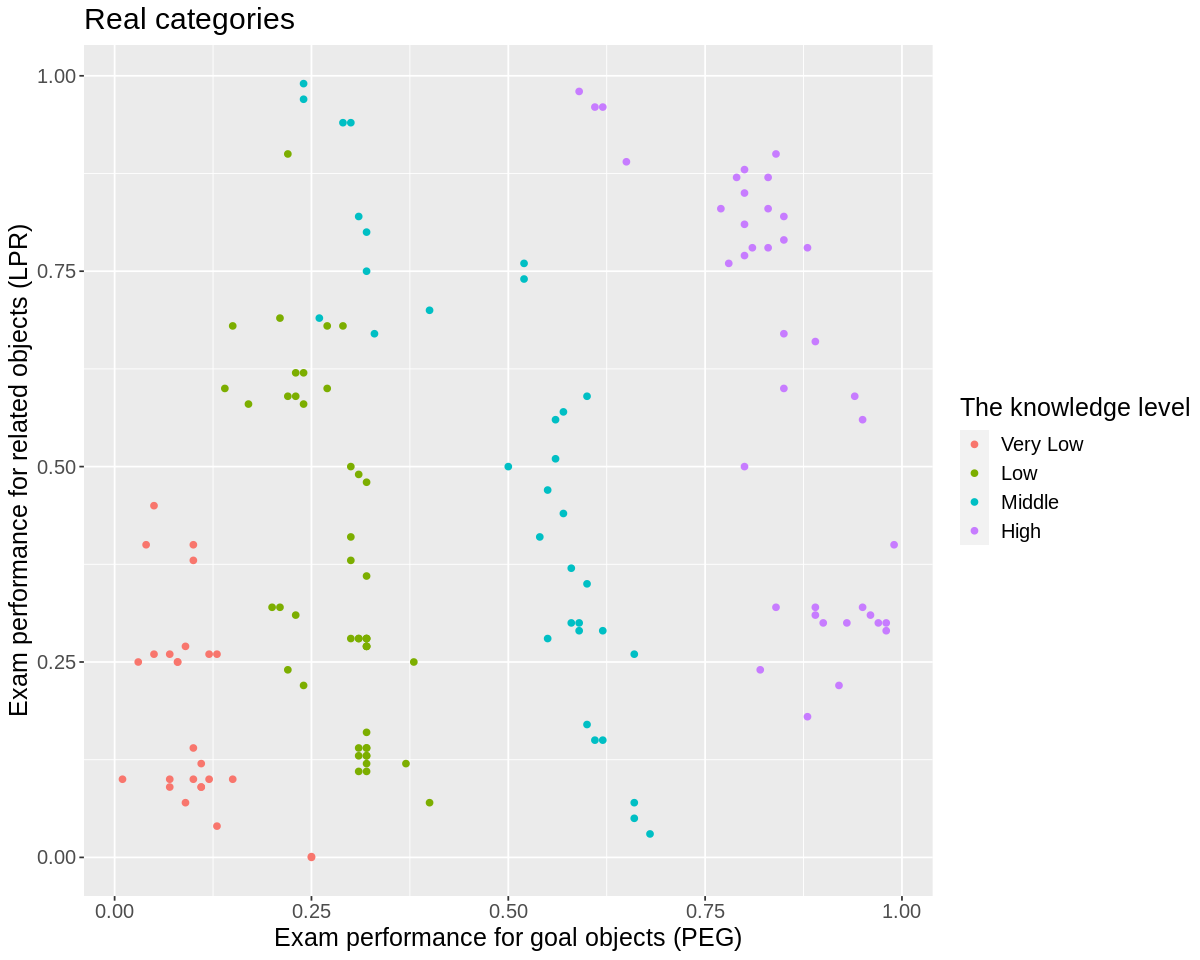

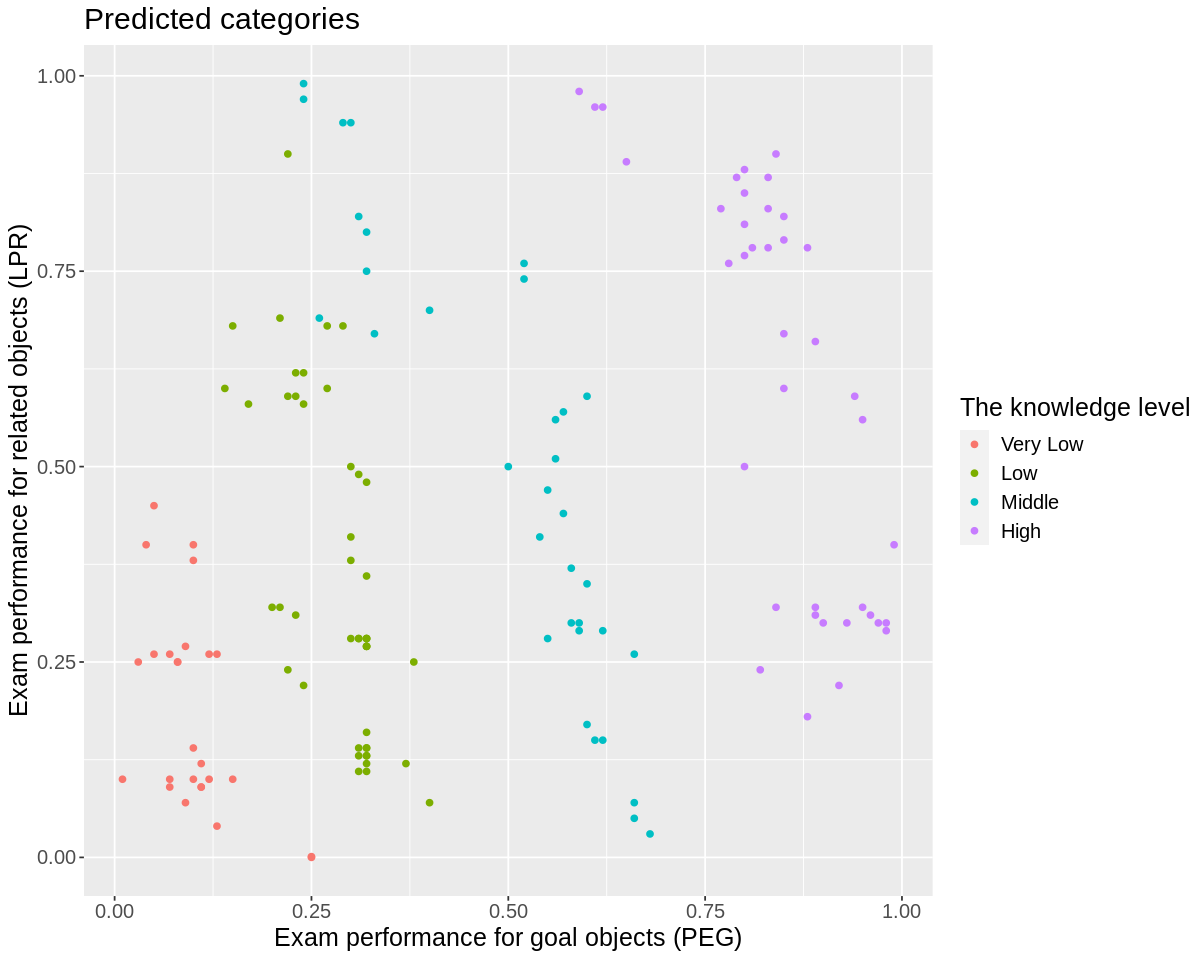

In [23]:
options(repr.plot.width = 10, repr.plot.height = 8)

testing_data_plot <- ggplot(user_testing, aes(x = PEG, y = LPR, colour = UNS)) +
geom_point() +
labs(x = "Exam performance for goal objects (PEG)", y = "Exam performance for related objects (LPR)", color = "The knowledge level") +
ggtitle("Real categories") +
theme(text = element_text(size = 15)) 

testing_data_plot

prediction_data_plot <- ggplot(user_testing, aes(x = PEG, y = LPR, colour = UNS)) +
geom_point() +
labs(x = "Exam performance for goal objects (PEG)", y = "Exam performance for related objects (LPR)", color = "The knowledge level") +
ggtitle("Predicted categories") +
theme(text = element_text(size = 15)) 

prediction_data_plot

As you can see, the prediction plot resembles to the actutal plot, which means that our prediction is fairly accurate.
It is not suprising becuase we already know that using our model for the testing data yields 92.4% accuracy.

<strong>Methods:</strong>

Explain how you will conduct either your data analysis and which variables/columns you will use. <br>
Describe at least one way that you will visualize the results.

We plan to conduct our data analysis using the categories STG (study time) , SCG (repetition number), and PEG (exam performance) categorised by UNS (knowledge level)  in order to classify based on data point nearest to the three metrics, the knowledge level. While performance on similar tasks could be important to our analysis, we will not use these categories as the data we want is task specific.
The visualisation will be a 3D scatter plot which plots SCG, PEG, and STG in the x, y, and z plane colour coded by training data knowledge level from which the data came from. In theory, we should see clusters of similar knowledge levels which will allow us to visualise test data when plotted.

<strong>Expected outcomes and significance:</strong>

What do you expect to find?<br>
What impact could such findings have?<br>
What future questions could this lead to?<br>

We expect to see that there is a correlation between each performance metric and the overall user knowledge. 
The implications of finding a correlation is that the findings could be generalised to look at athletic performance, job performance, and market performance. For example, a person trying out for a varsity sport could submit their training logs, win record, and years in the sport and could then be ranked prior to ever trying out. In sports where small advantages are paramount, data analysis of athletes could prove invaluable.
Some future questions that could be asked surround whether exam performance is indicative of knowledge or whether the amount of studying correlates as effectively as repetition to exam performance. Furthermore, what other metrics would be better in order to assess knowledge level.
